In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import ma
import xarray as xr
import geopandas as gpd
import pandas as pd
# requires cartopy to be installed
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import cartopy.crs as ccrs # for projection
import cartopy.feature as cfeature # for map features
from cartopy.util import add_cyclic_point
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
#from matplotlib.colors import TwoSlopeNorm
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import sys


In [40]:
filein = '/data/keeling/a/ctavila2/7_bootstrapping/gridmet_native_gridtmaxrhmin_oregon'

annual_mean = xr.open_dataset(filein)
lon_max = -121
lon_min = -123
lat_min = 38.5
lat_max = 40.5

annual_mean = annual_mean.where((annual_mean.lon >= lon_min) & (annual_mean.lon <= lon_max) & (annual_mean.lat >= lat_min) & (annual_mean.lat <= lat_max), drop=True)
annual_mean = annual_mean.groupby('time.year').mean(dim='time')
spatial_aggregate = annual_mean.mean(dim=['lon'])
spatial_aggregate = spatial_aggregate.mean(dim=['lat'])
# in this case spatial aggregate is the data I have, now I need to fit linear regression 
fwi_benchmark = spatial_aggregate.std(dim='year')
fwi = spatial_aggregate
poly_coeffs = fwi.FWI.polyfit(dim="year", deg=1).rename({"polyfit_coefficients":"FWI"}) 
poly_fits = xr.polyval(coord=fwi["year"], coeffs=poly_coeffs)
trend_slope = poly_coeffs.sel(degree=1).FWI
# trendline_values is out until 2060, and contains the entire projected trend. This is useful as we now can superimpose residuals with replacement to create new boootstrap iterations
# Good.
trendline_values = trend_slope.values * np.linspace(1979, 2090, 112) + poly_coeffs.sel(degree=0).FWI.values
trendline_values_44 = trend_slope * spatial_aggregate['year'] + poly_coeffs.sel(degree=0).FWI
# this gives me my mx+b value at each point, essentially giving me the predicted value from the linear regression
residuals = spatial_aggregate.FWI - trendline_values_44
standard_deviation_residuals = residuals.std(dim='year')

In [41]:
values_array_for_plot_original = []
length = np.linspace(1979, 2090, 112) 
for i in range(len(length)):
    values_array_for_plot_original.append((length[i]*poly_coeffs.sel(degree=1).FWI+poly_coeffs.sel(degree=0).FWI))
for i in range(len(length)):
    length[i]=values_array_for_plot_original[i]

### gridMET CI

#### NorCal

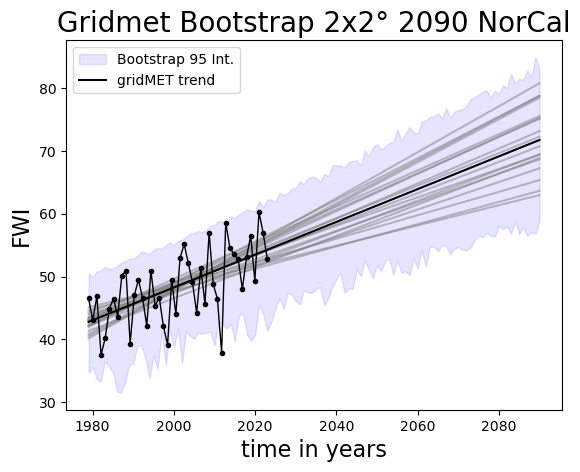

In [43]:
# this code does not recalulate residuals each iteration, this is the same method as how I implemented the spatial bootstrap. it just looks wrong.
num_iterations = 200

num_plots = 1
appended_points = []
all_trend_values = []
internal_variability_projected = []
for i in range(num_plots):

    # gives me residuals at each point and the predicated value at each point from the gridmet data
    actual_residuals = residuals.values
    actual_trendline_values = trendline_values
    # Perform bootstrap iterations where projection_2060_array is array of 2060 projections for each bootstrap
    for _ in range(num_iterations):
        # Resample with replacement, randomizing the residuals, we have two sets of residuals, one with size of 44, another with a size of 82, the first creates tbe trend, and the second is used 
        # for making the 95% interval
        resample_indices = np.random.choice(len(actual_residuals), len(actual_trendline_values), replace=True)
        boot_resid = actual_residuals[resample_indices] 
        boot_resid_44 = actual_residuals[np.random.choice(len(actual_residuals), len(trendline_values_44), replace=True)]
        # adding my randomized residuals back to my intial line of best fit for different values
        boot_sl = boot_resid + actual_trendline_values
        boot_sl_first_44 = boot_resid_44 + trendline_values_44
        appended_points.append(boot_sl)
    
        # Compute bootstrapped trend using np.polyfit (linear fit, degree=1)
        trend_coefficients = np.polyfit(range(len(boot_sl_first_44)), boot_sl_first_44, 1)
        # takes bootstrap trend projected values to 50 + initial length so to 2060 
        trend = np.polyval(trend_coefficients, range(len(boot_sl_first_44) + 68))
        all_trend_values.append(trend)
        # basically we fit a trend to bootstrapped first 44 years. We then add back internal variability to all 82 years for a resampled time series. 
        trend_with_internal_variability = trend + boot_resid
        internal_variability_projected.append(trend_with_internal_variability)
        # just takes the 2060 projected value
        
    
top_bounds_percentile = np.percentile(internal_variability_projected, 97.5, axis=0)
btm_bounds_percentile = np.percentile(internal_variability_projected, 2.5, axis=0)
# above is code for the confidence interval. 

x_values_trend = np.linspace(1979, 2090, 112) 
x_values_scatter = np.linspace(1979, 2023, 44) 

plt.fill_between(x_values_trend, top_bounds_percentile, btm_bounds_percentile, label="Bootstrap 95 Int.", color='b', alpha=.1)
#plt.fill_between(x_values_trend, top_bounds_percentile, btm_bounds, label="95 interval 2 STD", color='b', alpha=.1)
# Save the line object using pickle

NorCal_Confidence_Interval = xr.Dataset(
    {
        'top_bounds': top_bounds_percentile,
        'btm_bounds': btm_bounds_percentile
    }
)

# Save the data to a NetCDF file
NorCal_Confidence_Interval.to_netcdf('/data/keeling/a/ctavila2/7_bootstrapping/newbounds/confidence_interval_data_saved/Gridmet_NorCal_Confidence_Interval_95th')


plt.xlabel('time in years', fontsize=16)
plt.ylabel('FWI', fontsize=16)
plt.title('Gridmet Bootstrap 2x2° 2090 NorCal', fontsize=20)
for i in range(18):
    plt.plot(x_values_trend, all_trend_values[i], color='gray', alpha=.5)

plt.plot(x_values_scatter, spatial_aggregate.FWI, linestyle='-', marker='o', color='black',ms=3, linewidth=1)
plt.plot(x_values_trend, length, color='black', label='gridMET trend')
plt.legend(loc='upper left')
plt.savefig(f'/data/keeling/a/ctavila2/2024_FWI_CMIP5_Ensemble_Avila/final_figures/figure_3_socal_norcal_future_fwi_v2/GRIDMET_2090_2D_Bootstrap_tmaxrhmin_iterations_NorCal_WITHCONFIDENCE_{num_iterations}')
    

#### SoCal

In [45]:
filein = '/data/keeling/a/ctavila2/7_bootstrapping/gridmet_native_gridtmaxrhmin_oregon'

annual_mean = xr.open_dataset(filein)
lon_max = -116.5
lon_min = -118.5
lat_min = 34
lat_max = 36

annual_mean = annual_mean.where((annual_mean.lon >= lon_min) & (annual_mean.lon <= lon_max) & (annual_mean.lat >= lat_min) & (annual_mean.lat <= lat_max), drop=True)
annual_mean = annual_mean.groupby('time.year').mean(dim='time')
spatial_aggregate = annual_mean.mean(dim=['lon'])
spatial_aggregate = spatial_aggregate.mean(dim=['lat'])
# in this case spatial aggregate is the data I have, now I need to fit linear regression 
fwi_benchmark = spatial_aggregate.std(dim='year')
fwi = spatial_aggregate
poly_coeffs = fwi.FWI.polyfit(dim="year", deg=1).rename({"polyfit_coefficients":"FWI"}) 
poly_fits = xr.polyval(coord=fwi["year"], coeffs=poly_coeffs)
trend_slope = poly_coeffs.sel(degree=1).FWI
# trendline_values is out until 2060, and contains the entire projected trend. This is useful as we now can superimpose residuals with replacement to create new boootstrap iterations
# Good.
trendline_values = trend_slope.values * np.linspace(1979, 2090, 112) + poly_coeffs.sel(degree=0).FWI.values
trendline_values_44 = trend_slope * spatial_aggregate['year'] + poly_coeffs.sel(degree=0).FWI
# this gives me my mx+b value at each point, essentially giving me the predicted value from the linear regression
residuals = spatial_aggregate.FWI - trendline_values_44
standard_deviation_residuals = residuals.std(dim='year')

In [46]:
values_array_for_plot_original = []
length = np.linspace(1979, 2090, 112) 
for i in range(len(length)):
    values_array_for_plot_original.append((length[i]*poly_coeffs.sel(degree=1).FWI+poly_coeffs.sel(degree=0).FWI))
for i in range(len(length)):
    length[i]=values_array_for_plot_original[i]

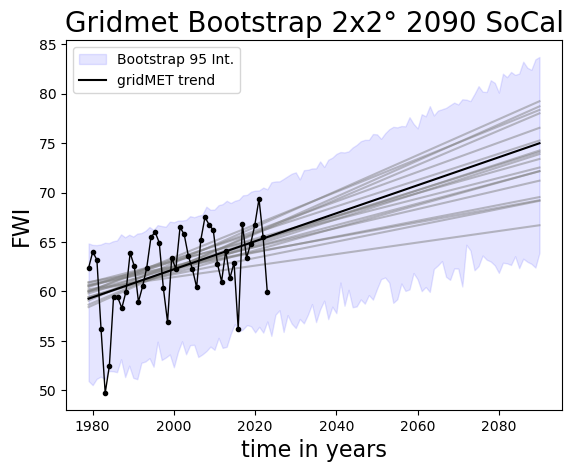

In [64]:
# this code does not recalulate residuals each iteration, this is the same method as how I implemented the spatial bootstrap. it just looks wrong.
num_iterations = 200

num_plots = 1
appended_points = []
all_trend_values = []
internal_variability_projected = []
for i in range(num_plots):

    # gives me residuals at each point and the predicated value at each point from the gridmet data
    actual_residuals = residuals.values
    actual_trendline_values = trendline_values
    # Perform bootstrap iterations where projection_2060_array is array of 2060 projections for each bootstrap
    for _ in range(num_iterations):
        # Resample with replacement, randomizing the residuals, we have two sets of residuals, one with size of 44, another with a size of 82, the first creates tbe trend, and the second is used 
        # for making the 95% interval
        resample_indices = np.random.choice(len(actual_residuals), len(actual_trendline_values), replace=True)
        boot_resid = actual_residuals[resample_indices] 
        boot_resid_44 = actual_residuals[np.random.choice(len(actual_residuals), len(trendline_values_44), replace=True)]
        # adding my randomized residuals back to my intial line of best fit for different values
        boot_sl = boot_resid + actual_trendline_values
        boot_sl_first_44 = boot_resid_44 + trendline_values_44
        appended_points.append(boot_sl)
    
        # Compute bootstrapped trend using np.polyfit (linear fit, degree=1)
        trend_coefficients = np.polyfit(range(len(boot_sl_first_44)), boot_sl_first_44, 1)
        # takes bootstrap trend projected values to 50 + initial length so to 2060 
        trend = np.polyval(trend_coefficients, range(len(boot_sl_first_44) + 68))
        all_trend_values.append(trend)
        # basically we fit a trend to bootstrapped first 44 years. We then add back internal variability to all 82 years for a resampled time series. 
        trend_with_internal_variability = trend + boot_resid
        internal_variability_projected.append(trend_with_internal_variability)
        # just takes the 2060 projected value
        
    
top_bounds_percentile = np.percentile(internal_variability_projected, 97.5, axis=0)
btm_bounds_percentile = np.percentile(internal_variability_projected, 2.5, axis=0)
# above is code for the confidence interval. 

x_values_trend = np.linspace(1979, 2090, 112) 
x_values_scatter = np.linspace(1979, 2023, 44) 

plt.fill_between(x_values_trend, top_bounds_percentile, btm_bounds_percentile, label="Bootstrap 95 Int.", color='b', alpha=.1)
#plt.fill_between(x_values_trend, top_bounds_percentile, btm_bounds, label="95 interval 2 STD", color='b', alpha=.1)
# Save the line object using pickle

NorCal_Confidence_Interval = xr.Dataset(
    {
        'top_bounds': top_bounds_percentile,
        'btm_bounds': btm_bounds_percentile
    }
)

# Save the data to a NetCDF file
NorCal_Confidence_Interval.to_netcdf('/data/keeling/a/ctavila2/7_bootstrapping/newbounds/confidence_interval_data_saved/Gridmet_SoCal_Confidence_Interval_95th')


plt.xlabel('time in years', fontsize=16)
plt.ylabel('FWI', fontsize=16)
plt.title('Gridmet Bootstrap 2x2° 2090 SoCal', fontsize=20)
for i in range(18):
    plt.plot(x_values_trend, all_trend_values[i], color='gray', alpha=.5)

plt.plot(x_values_scatter, spatial_aggregate.FWI, linestyle='-', marker='o', color='black',ms=3, linewidth=1)
plt.plot(x_values_trend, length, color='black', label='gridMET trend')
plt.legend(loc='upper left')
plt.savefig(f'/data/keeling/a/ctavila2/2024_FWI_CMIP5_Ensemble_Avila/final_figures/figure_3_socal_norcal_future_fwi_v2/4_0_GRIDMET_2090_2D_Bootstrap_tmaxrhmin_iterations_SoCal_WITHCONFIDENCE_{num_iterations}')

In [117]:
value_array_2030 = []
value_array_2060 = []
value_array_2090 = []
year = 51
for array in internal_variability_projected:
    value_array_2030.append(array[year])
year = 81
for array in internal_variability_projected:
    value_array_2060.append(array[year])
year = 111
for array in internal_variability_projected:
    value_array_2090.append(array[year])
_2030 = np.mean(value_array_2030)
_2060 = np.mean(value_array_2060)
_2090 = np.mean(value_array_2090)

In [118]:
print(_2030)
print(np.std(value_array_2030))

56.17884412953341
4.700536609201986


In [119]:
print(_2060)
print(np.std(value_array_2060))

64.14132966093639
5.525675766659821


In [120]:
print(_2090)
print(np.std(value_array_2090))

71.25498176009944
6.169235845753154


In [82]:
mean_convergence_array = np.linspace(2,50)
iteration_mean = []

In [38]:
for j in range(len(mean_convergence_array)):
    
    num_iterations = round(mean_convergence_array[j])
    
    num_plots = 1
    appended_points = []
    all_trend_values = []
    proj_2060_values = []
    for i in range(num_plots):
    
        # gives me residuals at each point and the predicated value at each point from the gridmet data
        actual_residuals = residuals.values
        actual_trendline_values = trendline_values.values
        # Perform bootstrap iterations where projection_2060_array is array of 2060 projections for each bootstrap
        for _ in range(num_iterations):
            # Resample with replacement, randomizing the residuals
            resample_indices = np.random.choice(len(actual_residuals), len(actual_residuals), replace=True)
            boot_resid = actual_residuals[resample_indices] 
            # adding my randomized residuals back to my intial line of best fit for different values
            boot_sl = boot_resid + actual_trendline_values
            appended_points.append(boot_sl)
        
            # Compute bootstrapped trend using np.polyfit (linear fit, degree=1)
            trend_coefficients = np.polyfit(range(len(boot_sl)), boot_sl, 1)
            # takes bootstrap trend projected values to 50 + initial length so to 2060 
            trend = np.polyval(trend_coefficients, range(len(boot_sl) + 38))
            proj_2060_values.append(trend[-1])
            all_trend_values.append(trend)
            # just takes the 2060 projected value
            
        # finishes with an array with 18 values, and take the average of the 18 2060 projections, replacing my 'blank' array at 
        # the appropriate lon / lat combination
    statistical_moment = np.mean(proj_2060_values)
    iteration_mean.append(statistical_moment)

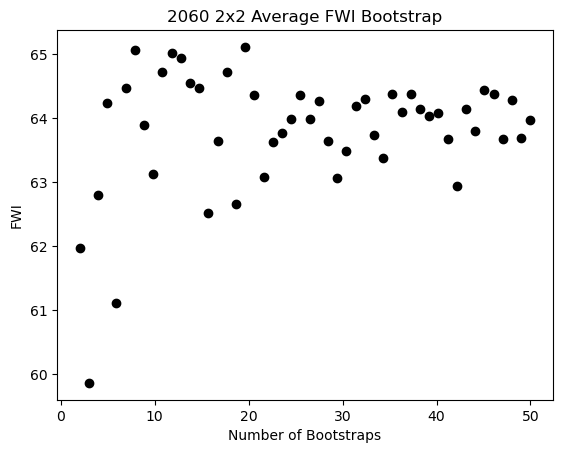

In [39]:
plt.ylabel('FWI')
plt.xlabel('Number of Bootstraps')
plt.title('2060 2x2 Average FWI Bootstrap')

plt.scatter(mean_convergence_array, iteration_mean, color = 'black', marker='o')
#plt.savefig('/data/keeling/a/ctavila2/7_bootstrapping/newbounds/time_series/bootstraps_versus_ensemble_members_2060_average')